# Word2Vec

In [1]:
num_threads = 4
w2vType = 'Word2Vec' # or Word2Vec 'FastText'
n_dim = 100
embed_name = '{}{}d'.format(w2vType, n_dim)
vocab_name = 'vocab.json'
min_count = 3
matrix_name = 'wv_matrix{}d'.format(n_dim)
#filename = 'mlds_hw2_2_data/clr_conversation.txt'

In [2]:
import json
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors, FastText
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE
import re

In [3]:
BOS = '<bos>'
EOS = '<eos>'
PAD = '<pad>'
UNK = '<unk>'
MAX_Q_LEN = 10
MAX_A_LEN = 10

In [4]:
sents = []
def loadsents(name):
    with open(name, 'r', encoding='utf-8') as f:
        for s in f:
            if s is not "+++$+++":
                sents.append([BOS] + s.split() + [EOS] + [PAD])
#loadsents(filename)
#sents[0]

In [5]:
for root, dirs, files in os.walk("../week3/"):
    for _dir in dirs:
        if(_dir.isnumeric()):
            dir_name = os.path.join(root, _dir);
            for f in os.listdir(dir_name):
                if(f.find('ipynb') == -1):
                    filename = os.path.join(dir_name, f)
                    loadsents(filename)
                

In [6]:
from gensim.models.callbacks import CallbackAny2Vec
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

In [7]:
epoch_logger = EpochLogger()
if w2vType == 'FastText':
    model = FastText(size=n_dim, window=5, min_count=min_count, workers=num_threads, callbacks=[epoch_logger])
else:
    model = Word2Vec(size=n_dim, window=5, min_count=min_count, workers=num_threads, callbacks=[epoch_logger])

model.build_vocab(sents)
total_examples = model.corpus_count
model.train(sents, total_examples=total_examples, epochs=5)

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end


(3350891, 5455625)

# 測試

In [8]:
word = 'patient'
print(word)
print(model.wv.similar_by_word(word))

patient
[("patient's", 0.9371249675750732), ('son', 0.928900957107544), ('patient,', 0.9283205270767212), ('daughter', 0.9169788360595703), ('time', 0.9159623384475708), ('called', 0.9090358018875122), ('wife', 0.8989265561103821), ('well', 0.8980377316474915), ('she', 0.8978705406188965), ('remained', 0.8942909240722656)]


# 假設用藥與病患身體器官的疾病有關，且該器官會影響病患生命週期

In [9]:
df = pd.read_pickle("../week5_6_7/id_life_med")
df

,life span,frequent medicine
1,46,H
10,34,m
100,16,C
101,14,C
102,27,po
103,19,m
104,1,F
105,8,C
106,127,m
107,15,F


In [10]:
with open("../week4/medicines_dict.json") as f:
    medicines_dict = json.load(f) 

with open("../week4/medicines_abb_map.json") as f:
    medicines_abb_map = json.load(f) 

# 查看每個藥關聯性最大的字

In [11]:
effective = []
for med in medicines_dict:
    try:
        print(med)
        print(model.wv.similar_by_word(med))
        effective.append(med)
    except KeyError:
        print("not in vocab")
    print("")
        

EG abb
not in vocab

ABG
[('load', 0.9400599002838135), ('Cordarone.', 0.9366122484207153), ('viral', 0.9337593913078308), ('gradient', 0.9316980242729187), ('PCR', 0.9294572472572327), ('10/12', 0.9275810122489929), ('D3', 0.9272825121879578), ('green', 0.9239431023597717), ('UCG', 0.9230741262435913), ('mildly', 0.920921802520752)]

ACE
not in vocab

ACTH
[('SpO2:98%(35%,L,VCR)', 0.9931048154830933), ('20.1', 0.9914975166320801), ('throat,', 0.9899711608886719), ('1.02', 0.9899263381958008), ('12.74', 0.9898020029067993), ('7.473', 0.989663302898407), ('99.9', 0.9894845485687256), ('LA:', 0.9893643856048584), ('SpO2:96%(%,L,)', 0.9891473650932312), ('Nervousness(-),', 0.9888490438461304)]

ADH
not in vocab

AED
[('adjust', 0.9479200839996338), ('titrate', 0.9426236748695374), ('diet', 0.9425045251846313), ('abx', 0.9406033754348755), ('Taper', 0.9391550421714783), ('teicoplanin', 0.9346248507499695), ('Try', 0.9316163659095764), ('Baktar', 0.9300134778022766), ('wet', 0.9295068383216

In [12]:
print(effective)

['ABG', 'ACTH', 'AED', 'ALP', 'ALT', 'AST', 'bid', 'BP', 'BUN', 'C', 'Ca', 'CBC', 'CK', 'Cl', 'cm', 'CNS', 'CO2', 'COPD', 'CPR', 'CSF', 'CT', 'DNA', 'ECG', 'EEG', 'EGD', 'ENT', 'ERCP', 'ESR', 'F', 'G', 'GI', 'GVHD', 'G6PD', 'GU', 'Hb', 'HCl', 'HCO3', 'HIV', 'ICU', 'IgA', 'INR', 'IU', 'IV', 'K', 'kg', 'L', 'LDH', 'M', 'm', 'MCH', 'MCHC', 'MCV', 'mEq', 'Mg', 'mg', 'MI', 'MIC', 'mL', 'mm', 'MRI', 'N', 'Na', 'NaCl', 'ng', 'O2', 'P', 'PCR', 'PET', 'pg', 'pH', 'PMN', 'po', 'PPD', 'ppm', 'prn', 'PT', 'PTT', 'RA', 'RBC', 'RNA', 'sc', 'SI', 'SLE', 'TB', 'TIBC', 'tid', 'TPN', 'URI', 'UTI', 'WBC', 'WHO', 'wt']


# 用爬蟲找出人體器官

In [13]:
import requests
url = "http://www.vhct.gov.tw/index.php?mo=SitePage&ac=sitepage_show&pgsn=92"
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
organ_table = pd.read_html(r.text)



In [14]:
print(organ_table[0])

            0                                                  1
0         NaN                                                NaN
1         中文名                                                英文名
2        人體器官                               Organs of Human Body
3          頭部                                               Head
4          頭髮                                   Hair of the head
5         後頭部                                   Back of the head
6           臉                                               Face
7           額  Forehead, frontal emninence, frontal bump, sup...
8           頰                                              Cheek
9           口                                              Mouth
10          頦                                               Chin
11          眼                                                Eye
12          鼻                                               Nose
13          眉                                            Eyebrow
14        上眼瞼            

In [15]:
organs = []
for ct,i in enumerate(list(organ_table[0].loc[: ,0])):
        if(ct>1):
            organs.append(i)

In [16]:
print(organs)

['人體器官', '頭部', '頭髮', '後頭部', '臉', '額', '頰', '口', '頦', '眼', '鼻', '眉', '上眼瞼', '下眼瞼', '睫毛', '虹膜', '瞳孔', '眼外肌', '眼球', '晶體狀', '玻璃體', '角膜', '視網膜', '鞏膜', '視神經', '盲點', '鼻唇溝', '人中（上唇中溝）', '頸', '項頸背', '喉（嚨）', '頜，顎', '上頜', '腦', '大腦', '小腦', '耳朵', '外耳', '耳廓', '耳垂', '外耳道', '中耳', '鼓膜', '鼓室', '聽小骨', '錘骨', '砧骨', '鐙骨', '耳咽管（咽鼓管）', '內耳', '半規管', '耳蝸', '前庭', '聽神經', '鼻子', '鼻梁', '鼻孔', '鼻中隔', '鼻腔', '鼻骨', '鼻旁竇', '鼻甲', '鼻後孔', '鼻翼', '鼻道', '鼻毛', '口腔和咽', '上唇', '下唇', '牙齦', '牙', '硬腭', '軟腭', '口角', '懸雍垂（小舌）', '（腭）扁桃體', '咽（峽）', '舌', '喉', '會厭', '聲帶', '聲門', '牙齒', '切齒門齒', '尖牙，犬牙', '雙尖牙，前磨牙，前臼齒', '磨牙，臼齒（後牙）', '乳牙（暫齒）', '智齒', '桓牙', '三尖牙', '牙槽', '牙周膜', '牙骨質', '牙冠', '牙根', '牙釉質', '牙質', '牙髓', '血管和神經', '人體', '肩', '肩胛', '腰', '腋，腋窩', '腋毛', '胸，胸膛', '乳房', '乳頭', '乳暈', '脅', '後臀', '臍', '腹部', '上腹', '下腹', '腹股溝', '屁股', '上臂', '前臂', '肘', '腕', '拳', '大腿', '膝，膝�', '膕窩', '小腿', '腓腸', '手', '拇指', '食指', '中指', '無名指，環指', '小指', '手背', '手掌', '撓（骨）側', '尺（骨）側', '指甲', '指紋', '魚際', '掌紋', '腕骨', '腕關節', '指骨', '指尖', '指關節', '腳，足', '拇指', '第二趾', '第三趾', '第四趾', '小趾', 

# 找出每個藥與哪個器官關聯性最強

In [17]:
ans_relation = {}
for med in effective:
    #print(med)
    best = 0;
    best_organ = "";
    for organ in organs:
        #model.wv.dot(med, )

        try:
            ans = model.similarity(med, organ)
            #print(organ)
            #print(ans)
            if(ans > best):
                best = ans;
                best_organ = organ
        except KeyError:
            pass
        
    ans_relation[med] = best_organ
        


/home/marvin/anaconda3/envs/py37cuda10/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


In [18]:
print(ans_relation)

{'ABG': '白血球', 'ACTH': '白血球', 'AED': '紅血球', 'ALP': '白血球', 'ALT': '紅血球', 'AST': '紅血球', 'bid': '眼', 'BP': '白血球', 'BUN': '紅血球', 'C': '白血球', 'Ca': '白血球', 'CBC': '白血球', 'CK': '白血球', 'Cl': '白血球', 'cm': '眼', 'CNS': '白血球', 'CO2': '白血球', 'COPD': '白血球', 'CPR': '眼', 'CSF': '白血球', 'CT': '紅血球', 'DNA': '紅血球', 'ECG': '白血球', 'EEG': '紅血球', 'EGD': '眼', 'ENT': '紅血球', 'ERCP': '白血球', 'ESR': '白血球', 'F': '白血球', 'G': '眼', 'GI': '白血球', 'GVHD': '白血球', 'G6PD': '白血球', 'GU': '紅血球', 'Hb': '白血球', 'HCl': '眼', 'HCO3': '白血球', 'HIV': '白血球', 'ICU': '紅血球', 'IgA': '紅血球', 'INR': '紅血球', 'IU': '眼', 'IV': '眼', 'K': '白血球', 'kg': '眼', 'L': '白血球', 'LDH': '紅血球', 'M': '白血球', 'm': '白血球', 'MCH': '紅血球', 'MCHC': '紅血球', 'MCV': '白血球', 'mEq': '眼', 'Mg': '白血球', 'mg': '眼', 'MI': '', 'MIC': '白血球', 'mL': '眼', 'mm': '眼', 'MRI': '白血球', 'N': '白血球', 'Na': '白血球', 'NaCl': '紅血球', 'ng': '眼', 'O2': '白血球', 'P': '白血球', 'PCR': '白血球', 'PET': '白血球', 'pg': '紅血球', 'pH': '白血球', 'PMN': '眼', 'po': '眼', 'PPD': '眼', 'ppm': '眼', 'prn': '紅血球', 'PT': '紅血球', 'PTT': '

# 得到的結論為：進安寧病房者通常為紅血球，白血球，眼睛有問題

In [19]:
with open("../week5_6_7/med_ct.json") as f:
    med_ct = json.load(f) 

In [20]:
import matplotlib.pyplot as plt


# 承上之前的資料，查詢用藥最高對應到的器官

<BarContainer object of 7 artists>

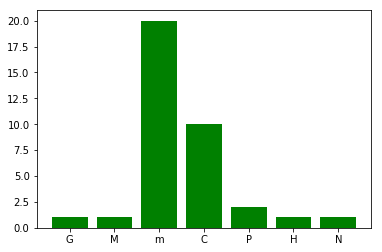

In [21]:
plt.bar(med_ct.keys(), med_ct.values(), 0.8, color='g')

In [22]:
for med in med_ct:
    try:
        print(med,ans_relation[med])
    except KeyError:
        pass

G 眼
M 白血球
m 白血球
C 白血球
P 白血球
N 白血球


# 其中又以m,C為最大的兩宗，白血球有問題最明顯

In [23]:
vocab = list(model.wv.vocab)
X = model[vocab]
print(X)

/home/marvin/anaconda3/envs/py37cuda10/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[[ 0.7699998   1.4425291  -0.3126468  ... -0.09262613  0.56723034
   0.52656364]
 [-0.00932874 -0.0314518  -0.00567347 ...  0.01613003 -0.01557585
  -0.00912353]
 [ 0.530521    0.45129982  0.6800689  ... -0.07346337  0.3931794
  -0.0053709 ]
 ...
 [ 0.00791551 -0.02567932 -0.02124962 ...  0.01945518 -0.00466109
  -0.03524414]
 [-0.00462836 -0.02827915 -0.02835808 ...  0.03078027 -0.00413213
  -0.04485026]
 [ 0.01183413 -0.02082951 -0.02224511 ...  0.0203494  -0.00982545
  -0.02150135]]


In [24]:
embedding_clusters = []
word_clusters = []
for word in vocab:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=2):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)

/home/marvin/anaconda3/envs/py37cuda10/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/marvin/anaconda3/envs/py37cuda10/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [28]:
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=250, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [31]:
import matplotlib.cm as cm
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


    


# Word2Vec visualize( choose 40 )

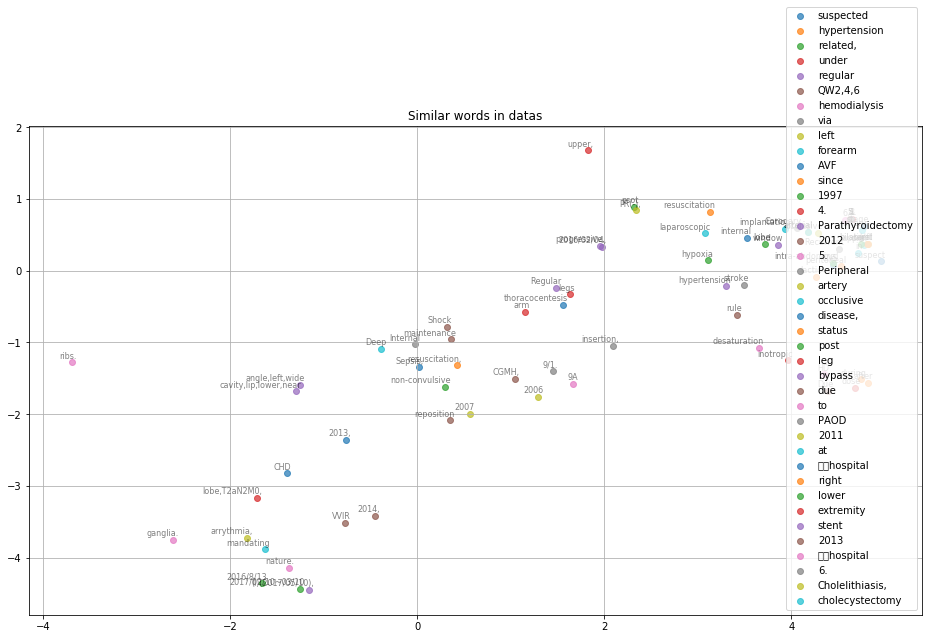

In [36]:

tsne_plot_similar_words('Similar words in datas', vocab[60:100], embeddings_en_2d[60:100], word_clusters[60:100], 0.7,
                        'similar_words.png')    

# 藥與器官關聯圖

In [37]:
a = []
b = []
c = []
for voc, emb, clus in zip(vocab, embeddings_en_2d, word_clusters):
    if(voc in effective or voc in organs):
        a.append(voc)
        b.append(emb)
        c.append(clus)

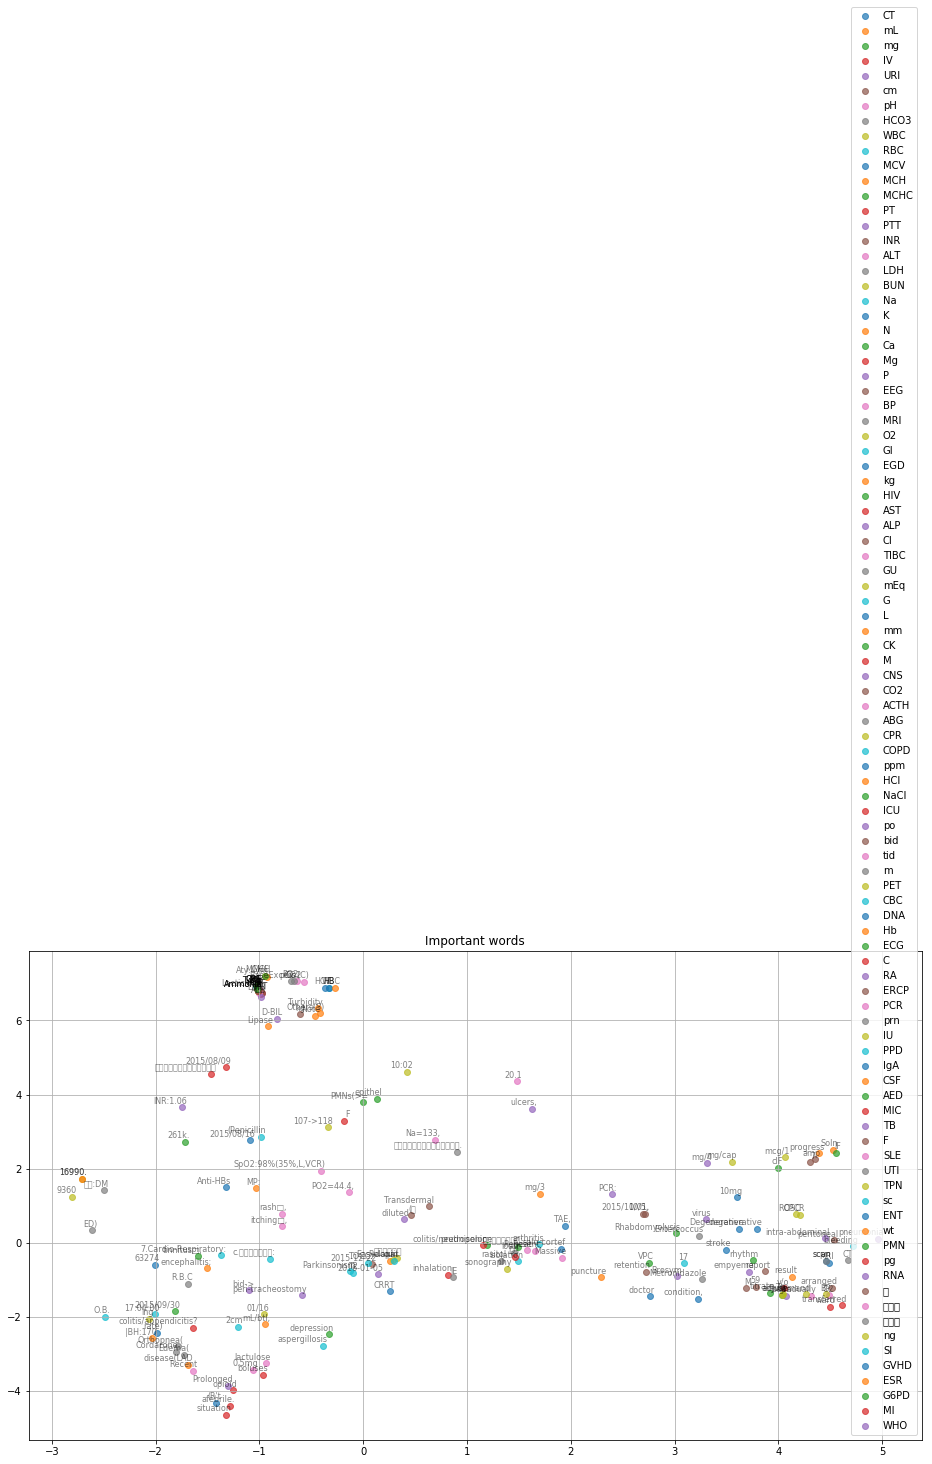

In [41]:
tsne_plot_similar_words('Important words', a, b, c, 0.7,
                        'similar_important_words.png')    